# Dask Array Support to AnnData

**Author:** Selman Özleyen

## Initializing

First let's do our imports and initialize adata objects with the help of the `adata_with_dask` function defined below.

In [1]:
import dask
import dask.array as da
import numpy as np
import pandas as pd
import anndata as ad

dask.config.set({"visualization.engine": "graphviz"});

In [2]:
random_state = da.random.RandomState(1234)
np.random.seed(1234)

def adata_with_dask(M, N):
    adata_dict = {}
    adata_dict["X"] = random_state.random((M, N))
    adata_dict["obsm"] = dict(
        a=da.random.random((M, 100)),
    )
    adata_dict["layers"] = dict(
        a=da.random.random((M, N)),
    )
    adata_dict["obs"] = pd.DataFrame(
        {"batch": np.random.choice(["a", "b"], M)},
        index=[f"cell{i:03d}" for i in range(M)],
    )
    adata_dict["var"] = pd.DataFrame(index=[f"gene{i:03d}" for i in range(N)])
    
    
    return ad.AnnData(**adata_dict)

Creating and inspecting a Dask-backed AnnData:

In [3]:
adata = adata_with_dask(8192, 8192)
adata

AnnData object with n_obs × n_vars = 8192 × 8192
    obs: 'batch'
    obsm: 'a'
    layers: 'a'

## Representation of Dask Arrays

[Dask arrays](https://docs.dask.org/en/stable/array.html) consist of "chunks," which are computed lazily, and can be distributed across machines. In the figure below, each small square represents a chunk of the overall Dask array:

In [4]:
adata.X

dask.array<random_sample, shape=(8192, 8192), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>

In [5]:
adata.obsm['a']

dask.array<random_sample, shape=(8192, 100), dtype=float64, chunksize=(8192, 100), chunktype=numpy.ndarray>

## The Computation Graph
Operations on Dask arrays aren't performed instantly. Instead, a computation graph is built, which Dask can later optimize before executing. This also means Dask doesn't occupy resources for results we expect later. Below is a representation of the chunks we initially created.

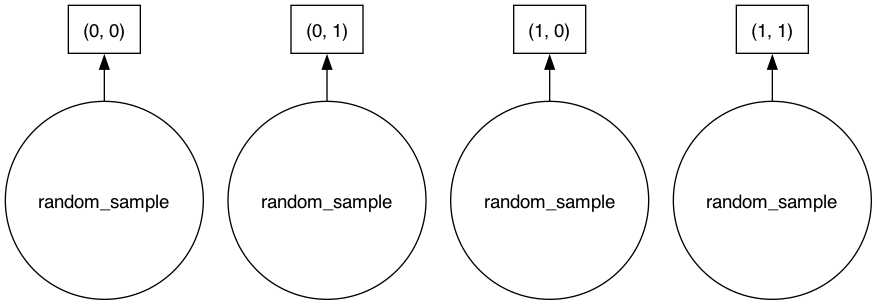

In [6]:
adata.X.visualize()

We now show an example for this computation graph on dask arrays to understand it better. This part is not technically relevant to AnnData.

In [7]:
xsum = adata.X.sum(axis=1)  # Sum each row of the array
xsum

dask.array<sum-aggregate, shape=(8192,), dtype=float64, chunksize=(4096,), chunktype=numpy.ndarray>

Note that this computation hasn't been performed yet, but was saved, to run later. Investigating the computation graph, we see that some chunks aren't dependent on others. This allows Dask to parallelize computations, and store chunks that depend on each other on the same machine. For this simple exercise, all chunks are stored on one machine, but this is especially useful with larger data, where that is impossible.

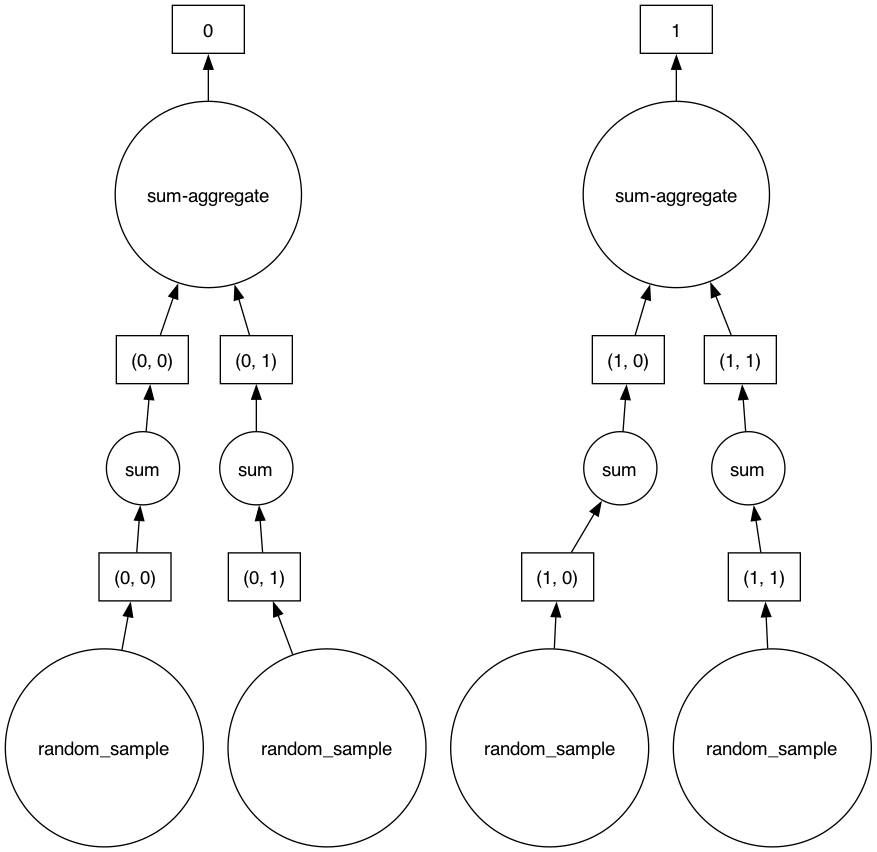

In [8]:
xsum.visualize()

Despite creating the graph above, nothing has changed with our original anndata:

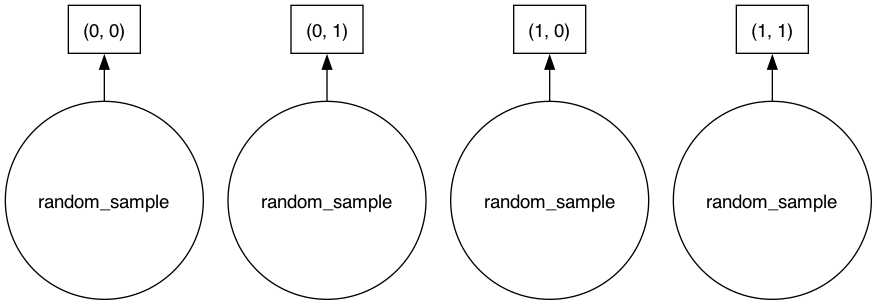

In [9]:
adata.X.visualize()

## Concatenation

In this section we will cover concatenating Dask-backed AnnData objects. First, we create another anndata object to concatenate with:

In [10]:
adata2 = adata_with_dask(8192, 8192)
adata2

AnnData object with n_obs × n_vars = 8192 × 8192
    obs: 'batch'
    obsm: 'a'
    layers: 'a'

The `X` attribute of this adata also consists of four chunks:

In [11]:
adata2.X

dask.array<random_sample, shape=(8192, 8192), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>

In [12]:
adata_concat = ad.concat([adata, adata2],index_unique='id')

When we concatenate the two adatas, the resulting `X` consists of the eight chunks from the source adatas:

In [13]:
adata_concat.X

dask.array<concatenate, shape=(16384, 8192), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>

Looking at the computation graph, we can confirm that the new `X`'s chunks are just those of the source `X`'s.

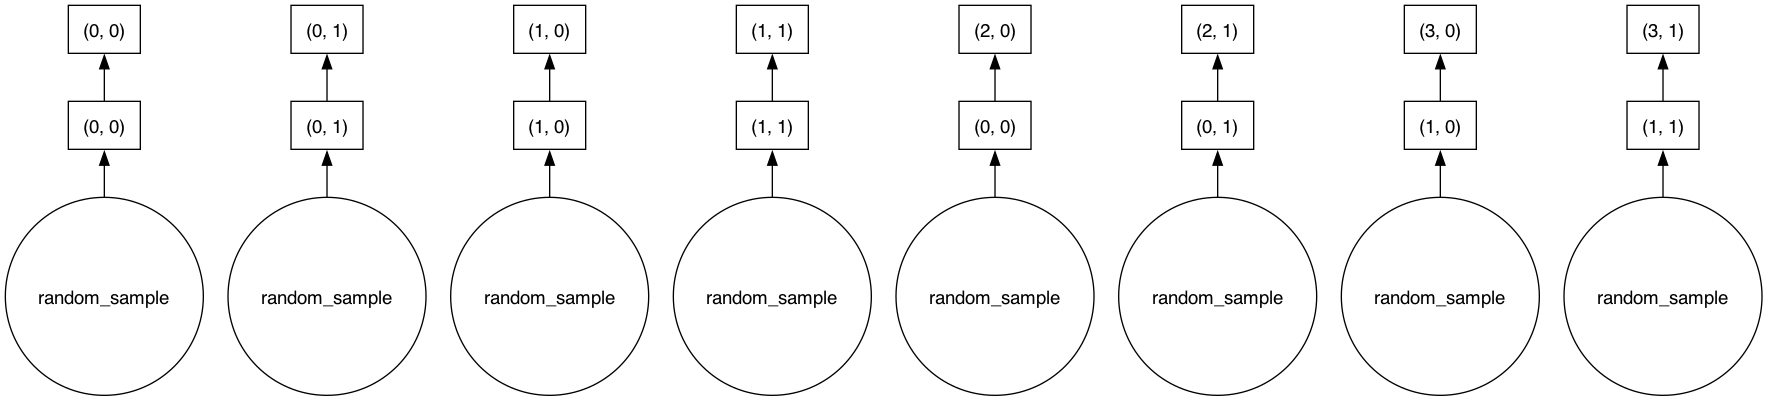

In [14]:
adata_concat.X.visualize()

The new adata's `obsm` is similar: one chunk from each input adata, stacked.

In [15]:
adata_concat.obsm['a']

dask.array<concatenate, shape=(16384, 100), dtype=float64, chunksize=(8192, 100), chunktype=numpy.ndarray>

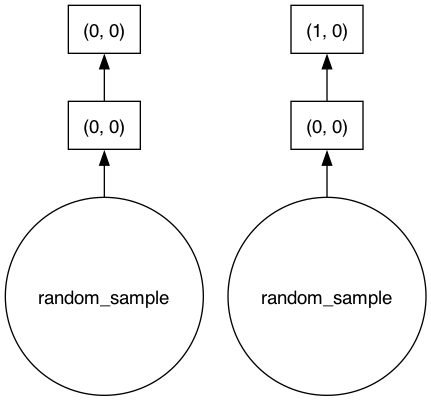

In [16]:
adata_concat.obsm['a'].visualize()

## Views

Let's see how our views of AnnData objects play with Dask arrays.

### Slice View



We take a slice of the concatenated adatas. This operation returns a view of the adata which means that the resulting adata holds a view of the source adata's Dask array, namely the `DaskArrayView` class,  which is a completely different object than Dask array.

In [17]:
adata_slice_view = adata_concat[:500, :][:, :500]

The result is still a "lazy" Dask array:

In [18]:
adata_slice_view.X

dask.array<getitem, shape=(500, 500), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>

Calling `.compute()` materializes the slice into memory:

In [19]:
adata_slice_view.X.compute()

array([[0.0108367 , 0.28382864, 0.9360798 , ..., 0.52618062, 0.59004764,
        0.62039745],
       [0.32746127, 0.76554293, 0.44635843, ..., 0.72054517, 0.17201924,
        0.67597256],
       [0.70930772, 0.10462946, 0.66942566, ..., 0.46777305, 0.85501837,
        0.66550968],
       ...,
       [0.88829253, 0.03652444, 0.73521986, ..., 0.36912615, 0.33270242,
        0.99651464],
       [0.3738551 , 0.2144048 , 0.05395079, ..., 0.3716109 , 0.78776837,
        0.25162666],
       [0.60050641, 0.62585592, 0.98995585, ..., 0.03956337, 0.30491447,
        0.97628516]], shape=(500, 500))

But the original adata remains unchanged:

In [20]:
adata_concat.X

dask.array<concatenate, shape=(16384, 8192), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>

### Index List View

In [21]:
small_view = adata_concat[[12, 12, 3, 5, 53],[1, 2, 5]]
small_view

View of AnnData object with n_obs × n_vars = 5 × 3
    obs: 'batch'
    obsm: 'a'
    layers: 'a'

In [22]:
small_view.X

dask.array<getitem, shape=(5, 3), dtype=float64, chunksize=(5, 3), chunktype=numpy.ndarray>

### View by Category

In [23]:
mask = adata_concat.obs['batch'] == 'b'
categ_view = adata_concat[mask]

`obs` is an in-memory `pd.DataFrame`, so `adata_concat.obs['batch'] == 'b'` is a boolean `pd.Series`, and each chunk is "masked" by its corresponding range.

In [24]:
categ_view.X

dask.array<getitem, shape=(8168, 8192), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>

The resulting number of rows matches the number of `True` elements in the `mask`:

In [25]:
mask.sum()

np.int64(8168)

## To Memory

In [26]:
adata_concat.X

dask.array<concatenate, shape=(16384, 8192), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>

Here no copies are made, only the result of the lazy object is asked to be materialized.

In [27]:
adata_mem = adata_concat.to_memory(copy=False)
adata_mem.X

array([[0.0108367 , 0.28382864, 0.9360798 , ..., 0.92309787, 0.05939681,
        0.89591249],
       [0.32746127, 0.76554293, 0.44635843, ..., 0.02995244, 0.71811621,
        0.49264767],
       [0.70930772, 0.10462946, 0.66942566, ..., 0.15158576, 0.65742044,
        0.45014383],
       ...,
       [0.39549188, 0.92320419, 0.17637048, ..., 0.65675201, 0.27528794,
        0.17191972],
       [0.88487203, 0.5408022 , 0.80737639, ..., 0.55172944, 0.9373794 ,
        0.34597532],
       [0.30054249, 0.53527011, 0.15589345, ..., 0.00963602, 0.33234463,
        0.33513417]], shape=(16384, 8192))

If you want to both materialize the result and copy.

In [28]:
del adata_mem

In [29]:
adata_mem = adata_concat.to_memory(copy=True)
adata_mem.X

array([[0.0108367 , 0.28382864, 0.9360798 , ..., 0.92309787, 0.05939681,
        0.89591249],
       [0.32746127, 0.76554293, 0.44635843, ..., 0.02995244, 0.71811621,
        0.49264767],
       [0.70930772, 0.10462946, 0.66942566, ..., 0.15158576, 0.65742044,
        0.45014383],
       ...,
       [0.39549188, 0.92320419, 0.17637048, ..., 0.65675201, 0.27528794,
        0.17191972],
       [0.88487203, 0.5408022 , 0.80737639, ..., 0.55172944, 0.9373794 ,
        0.34597532],
       [0.30054249, 0.53527011, 0.15589345, ..., 0.00963602, 0.33234463,
        0.33513417]], shape=(16384, 8192))

## IO operations

Dask-backed adatas can be saved as `h5ad` or [Zarr](https://zarr.dev/), but note that this materializes the lazy objects.

Reading `h5ad`/Zarr files doesn't currently support loading dask arrays.

### Write h5ad

In [30]:
adata = adata_with_dask(100, 100)

In [31]:
adata.write_h5ad('a1.h5ad')

In [32]:
adata.X

dask.array<random_sample, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

### Read h5ad

In [33]:
h5ad_adata = ad.read_h5ad('a1.h5ad')

In [34]:
h5ad_adata.X

array([[0.37998954, 0.63980702, 0.26274465, ..., 0.7947513 , 0.17282635,
        0.9798995 ],
       [0.90467226, 0.35865872, 0.93086325, ..., 0.68528928, 0.93964226,
        0.09023157],
       [0.61849182, 0.08411113, 0.69053532, ..., 0.95105956, 0.66507056,
        0.72127758],
       ...,
       [0.11676974, 0.89049662, 0.3712748 , ..., 0.81927027, 0.28500624,
        0.61784644],
       [0.84302444, 0.40759716, 0.49456791, ..., 0.71104587, 0.18751357,
        0.48834237],
       [0.97498015, 0.94652343, 0.29063082, ..., 0.7025696 , 0.9207584 ,
        0.50216227]], shape=(100, 100))

### Write zarr

In [35]:
adata.write_zarr('a2.zarr')

In [36]:
adata.X

dask.array<random_sample, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

### Read zarr

In [37]:
zarr_adata = ad.read_zarr('a2.zarr')

In [38]:
zarr_adata.X

array([[0.37998954, 0.63980702, 0.26274465, ..., 0.7947513 , 0.17282635,
        0.9798995 ],
       [0.90467226, 0.35865872, 0.93086325, ..., 0.68528928, 0.93964226,
        0.09023157],
       [0.61849182, 0.08411113, 0.69053532, ..., 0.95105956, 0.66507056,
        0.72127758],
       ...,
       [0.11676974, 0.89049662, 0.3712748 , ..., 0.81927027, 0.28500624,
        0.61784644],
       [0.84302444, 0.40759716, 0.49456791, ..., 0.71104587, 0.18751357,
        0.48834237],
       [0.97498015, 0.94652343, 0.29063082, ..., 0.7025696 , 0.9207584 ,
        0.50216227]], shape=(100, 100))

Notice how they are loaded as arrays rather than dask arrays.

## Dask Array Support for Other Fields

This is the list of operations and in which fields they are supported, although some might have not been covered in this tutorial.

The following work with operations anndata supported before are also supported now with Dask arrays:
- anndata.concat()
- Views
- copy()
- to_memory() (changed behaviour)
- read/write on h5ad/zarr

**X, obsm, varm, obsp, varp, layers, uns, and raw** attributes are all supported and tested.

Note: scipy.sparse array wrapped with dask array doesn't play well. This is mainly because of the inconsistent numpy api support of scipy.sparse. Even though not explicitly tested, a sparse array that supports the numpy api should theoretically work well.